# Random forest - 150m

In [1]:
import numpy as np
import pandas as pd
import geopandas as gpd
import shapely
from shapely.wkt import loads
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from scipy.cluster.hierarchy import linkage
import matplotlib.pyplot as plt
import seaborn as sns
import altair as alt
from mpl_toolkits.mplot3d import Axes3D
alt.data_transformers.enable("vegafusion")
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

### Choose night time temperatures in July

In [6]:
temp =  pd.read_csv('/Users/lisawink/Documents/paper1/data/gap_filled_data_ta_rh.csv')
temp['datetime_UTC']=pd.to_datetime(temp['datetime_UTC'])
temp = temp[temp['variable']=='Ta_deg_C']

In [7]:
# choose all times between 11pm and 6am in July
temp = temp[(temp['datetime_UTC'].dt.hour>=23) | (temp['datetime_UTC'].dt.hour<6)]
temp = temp[(temp['datetime_UTC'].dt.month==7)]
temp_result = temp.groupby('station_id').mean(numeric_only=True)

In [8]:
print(temp_result)

                value
station_id           
FRASHA      17.384516
FRBETZ      18.499631
FRBRUH      18.681705
FRDIET      16.922488
FRDREI      18.395069
FREBNE      15.556083
FREICH      16.675346
FRFRIE      18.341014
FRGART      18.357788
FRGLBA      16.420968
FRGUNT      16.746728
FRHAID      18.344839
FRHBHF      19.055853
FRHERD      19.007650
FRHOCH      16.778479
FRHOLZ      17.871567
FRIHOC      17.191336
FRINST      19.600138
FRKART      19.692673
FRLAND      17.699447
FRLORE      17.066313
FRMERZ      16.635161
FRMESS      18.795806
FROPFS      16.558940
FROWIE      18.364977
FRPDAS      18.493917
FRRIES      18.808387
FRSEEP      18.413134
FRSTGA      18.632488
FRSTGE      18.516221
FRSTUH      18.801060
FRTIEN      16.376590
FRUNIK      19.291567
FRUWIE      18.135991
FRVAUB      17.823272
FRWAHS      15.966452
FRWEIN      18.648525
FRWILD      17.125023
FRWITT      18.801705
FRWSEE      17.621198
FRZAHR      18.148940


In [20]:
df = temp_result

Standard Deviation: 1.0177418881911355


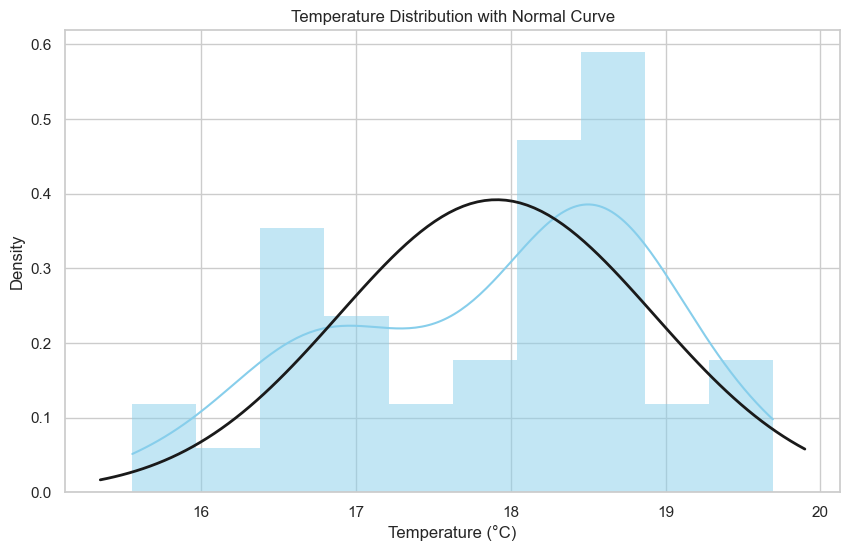

In [21]:
# Calculate the standard deviation
std_dev = np.std(df['value'])
print(f"Standard Deviation: {std_dev}")

# Plotting the histogram and the normal distribution curve
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Plot the histogram
sns.histplot(df['value'], kde=True, stat="density", bins=10, color='skyblue', linewidth=0)

# Plot the normal distribution
mean = np.mean(df['value'])
xmin, xmax = plt.xlim()  # Get the limits of the x-axis
x = np.linspace(xmin, xmax, 100)
p = 1/(std_dev * np.sqrt(2 * np.pi)) * np.exp(- 0.5 * (  (x - mean) / std_dev )**2 )
plt.plot(x, p, 'k', linewidth=2)

# Title and labels
plt.title('Temperature Distribution with Normal Curve')
plt.xlabel('Temperature (°C)')
plt.ylabel('Density')

# Show plot
plt.show()

### Random forest with all 2d urban form parameters

In [22]:
# import and drop index
params = gpd.read_parquet('/Users/lisawink/Documents/paper1/data/processed_data/processed_station_params_150.parquet')
params = params[params['station_id']!='FRTECH']
params.index = params['station_id']

In [23]:
items = [
    'BuAre_count', 'BuAre_sum', 'BuAre_mean', 'BuAre_std', 
    'BuHt_mean', 'BuHt_std', 
    'BuPer_mean', 'BuPer_std', 
    'BuLAL_mean', 'BuLAL_std', 
    'BuCCD_mean_mean', 'BuCCD_mean_std', 
    'BuCor_mean', 'BuCor_std', 
    'CyAre_sum', 'CyAre_mean', 'CyAre_std', 
    'CyInd_mean', 'CyInd_std', 
    'BuCWA_mean', 'BuCWA_std', 
    'BuCon_mean', 'BuCon_std', 
    'BuElo_mean', 'BuElo_std', 
    'BuERI_mean', 'BuERI_std', 
    'BuFR_mean', 'BuFR_std', 
    'BuFF_mean', 'BuFF_std', 
    'BuFD_mean', 'BuFD_std', 
    'BuRec_mean', 'BuRec_std', 
    'BuShI_mean', 'BuShI_std', 
    'BuSqC_mean', 'BuSqC_std', 
    'BuSqu_mean', 'BuSqu_std', 
    'BuAdj', 
    'BuIBD', 
    'BuSWR_mean', 'BuSWR_std', 
    'BuOri_mean', 'BuOri_std', 
    'BuAli_mean', 'BuAli_std', 
    'StrAli_mean', 'StrAli_std', 
    'StrW_mean', 'StrW_std', 
    'StrWD_mean', 'StrWD_std', 
    'StrOpe_mean', 'StrOpe_std', 
    'StrHW_mean', 'StrHW_std', 
    'StrLen_mean', 'StrLen_std', 
    'StrCNS_mean', 'StrCNS_std', 
    'BpM_mean', 'BpM_std', 
    'StrLin_mean', 'StrLin_std', 
    'StrClo400_mean', 'StrClo400_std', 
    'StrBet400_mean', 'StrBet400_std', 
    'StrSCl_mean', 'StrSCl_std', 
    'StrCyc400_mean', 'StrCyc400_std', 
    'StrENR400_mean', 'StrENR400_std', 
    'StrGam400_mean', 'StrGam400_std', 
    'StrDeg_mean', 'StrDeg_std', 
    'StrMes400_mean', 'StrMes400_std',
    'StrClo1200_mean', 'StrClo1200_std', 
    'StrBet1200_mean', 'StrBet1200_std',  
    'StrCyc1200_mean', 'StrCyc1200_std', 
    'StrENR1200_mean', 'StrENR1200_std', 
    'StrGam1200_mean', 'StrGam1200_std', 
    'StrMes1200_mean', 'StrMes1200_std'
]

In [24]:
params = params[items]
params = params.merge(temp_result, left_on='station_id', right_on='station_id',how='inner')

In [25]:
# standardize data
scaler = StandardScaler()
params_scaled = scaler.fit_transform(params)

In [26]:
params_scaled = pd.DataFrame(params_scaled, columns=params.columns, index=params.index)
params_scaled = params_scaled.dropna(thresh=params_scaled.shape[0] - 7, axis=1)

In [39]:
params_scaled

,BuAre_count,BuAre_sum,BuAre_mean,BuAre_std,BuHt_mean,BuHt_std,BuPer_mean,BuPer_std,BuLAL_mean,BuLAL_std,...,StrBet1200_std,StrCyc1200_mean,StrCyc1200_std,StrENR1200_mean,StrENR1200_std,StrGam1200_mean,StrGam1200_std,StrMes1200_mean,StrMes1200_std,value
station_id,,,,,,,,,,,,,,,,,,,,,
FRASHA,-0.151218,-0.698961,-0.573337,-0.412014,-0.335127,0.174435,-0.807737,-0.442441,-0.768236,-0.314315,...,-0.787959,-0.933663,0.453194,-1.657161,4.105727,1.049743,2.190768,-0.821892,4.165193,-1.004757
FRBETZ,0.655708,-0.178180,-0.595290,-0.338512,-0.460708,0.974901,-0.841954,-0.171390,-0.842890,-0.382823,...,-0.703986,-0.985414,-0.316479,-1.587750,0.000030,-1.896390,1.152995,-1.796849,0.269095,0.371544
FRBRUH,-1.021849,2.150590,3.853515,3.728448,-0.489649,0.290844,2.800428,2.567869,2.656478,2.522363,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.596264
FRDIET,-1.489017,-1.628296,-0.008758,0.380878,0.207661,2.448707,-0.119408,1.502863,-0.349207,1.110792,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.575002
FRDREI,-0.745796,-0.359651,0.074468,-0.150227,1.466217,-0.036835,0.402900,-0.065318,0.443798,0.114993,...,0.636933,-0.689572,-0.403257,-0.932362,-0.275234,-1.294405,-0.178260,-1.144177,-0.278095,0.242491
FRFRIE,-1.446548,-1.604475,-0.281384,-0.779732,-1.616037,-1.792142,-0.078981,-1.274862,0.067646,-1.058390,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.175775
FRGART,1.972272,-0.553351,-0.843576,-0.839161,-0.264253,-1.648366,-1.035620,-1.382806,-0.897841,-1.275953,...,-0.566327,-0.413855,-0.636243,-0.363460,-0.407658,-0.655317,-0.523455,-0.516543,-0.462325,0.196478
FRGLBA,-0.023809,-0.832890,-0.673570,-0.731444,-0.099075,-0.133213,-0.899720,-0.948917,-0.886270,-0.908715,...,NaN,-0.478256,NaN,0.447694,NaN,0.412050,NaN,0.479592,NaN,-2.193990
FRGUNT,0.422124,-0.755875,-0.736395,-0.729555,-0.810139,-0.437037,-1.049650,-0.921379,-1.019463,-0.904470,...,-0.796308,-0.961264,-0.821555,-0.741578,-0.535972,-0.583405,-1.003207,-0.632990,-0.683488,-1.791930


In [37]:
X = params_scaled.drop('value', axis=1)
y = params_scaled['value']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

rf = RandomForestRegressor(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)

mse = mean_squared_error(y_test, y_pred)

print('RMSE:', np.sqrt(mse))

RMSE: 0.9323908188728176


In [40]:
# print r squared of rf model
r2_score(y_test, y_pred)


0.27453372557670896

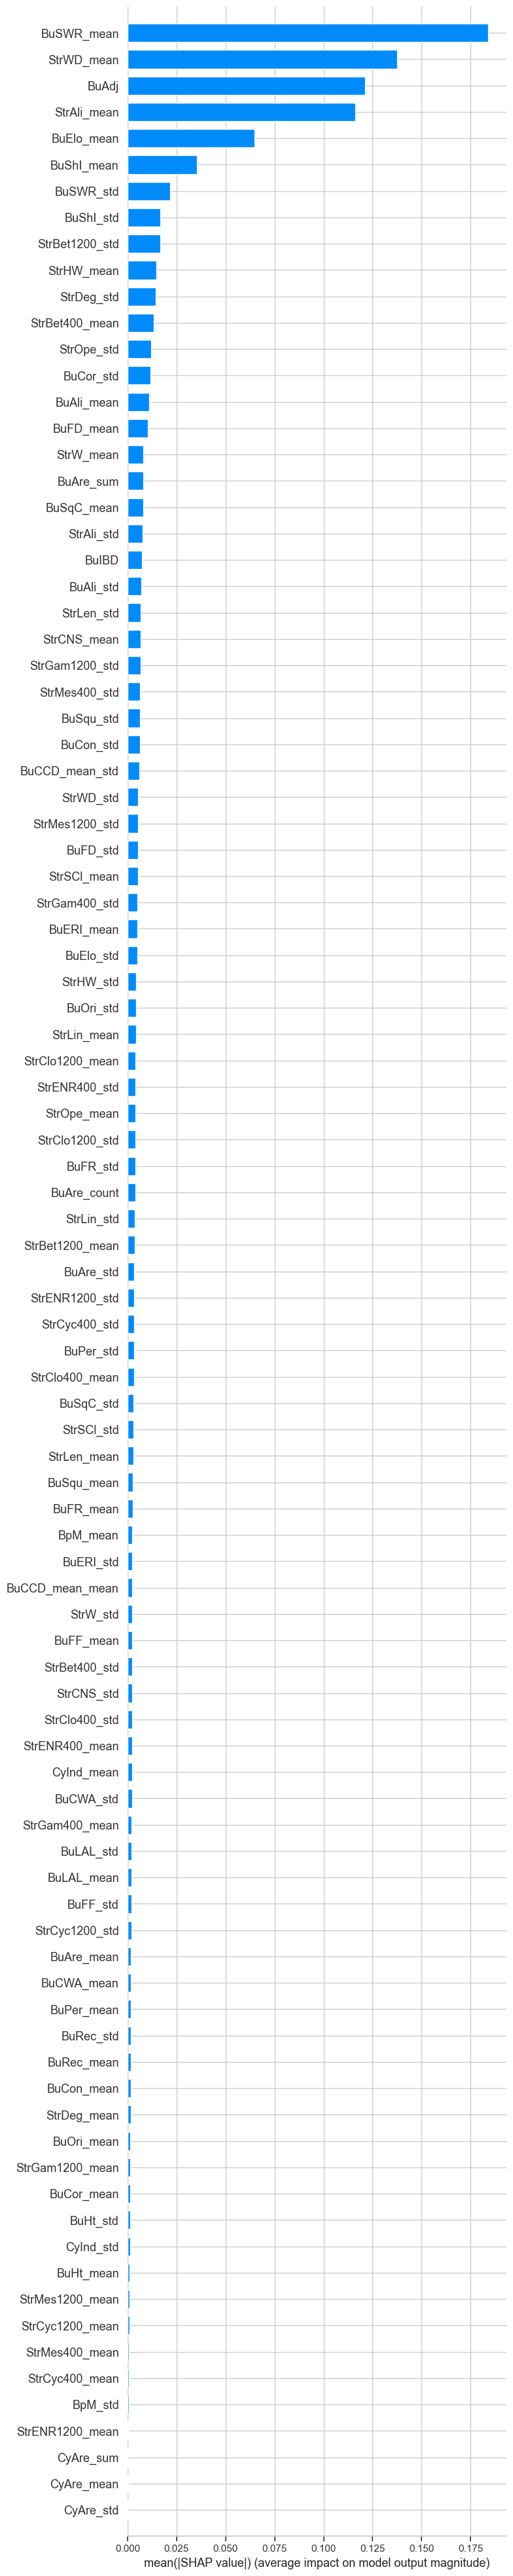

In [30]:
# show shap values for random forest
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar',max_display=X_test.shape[1])

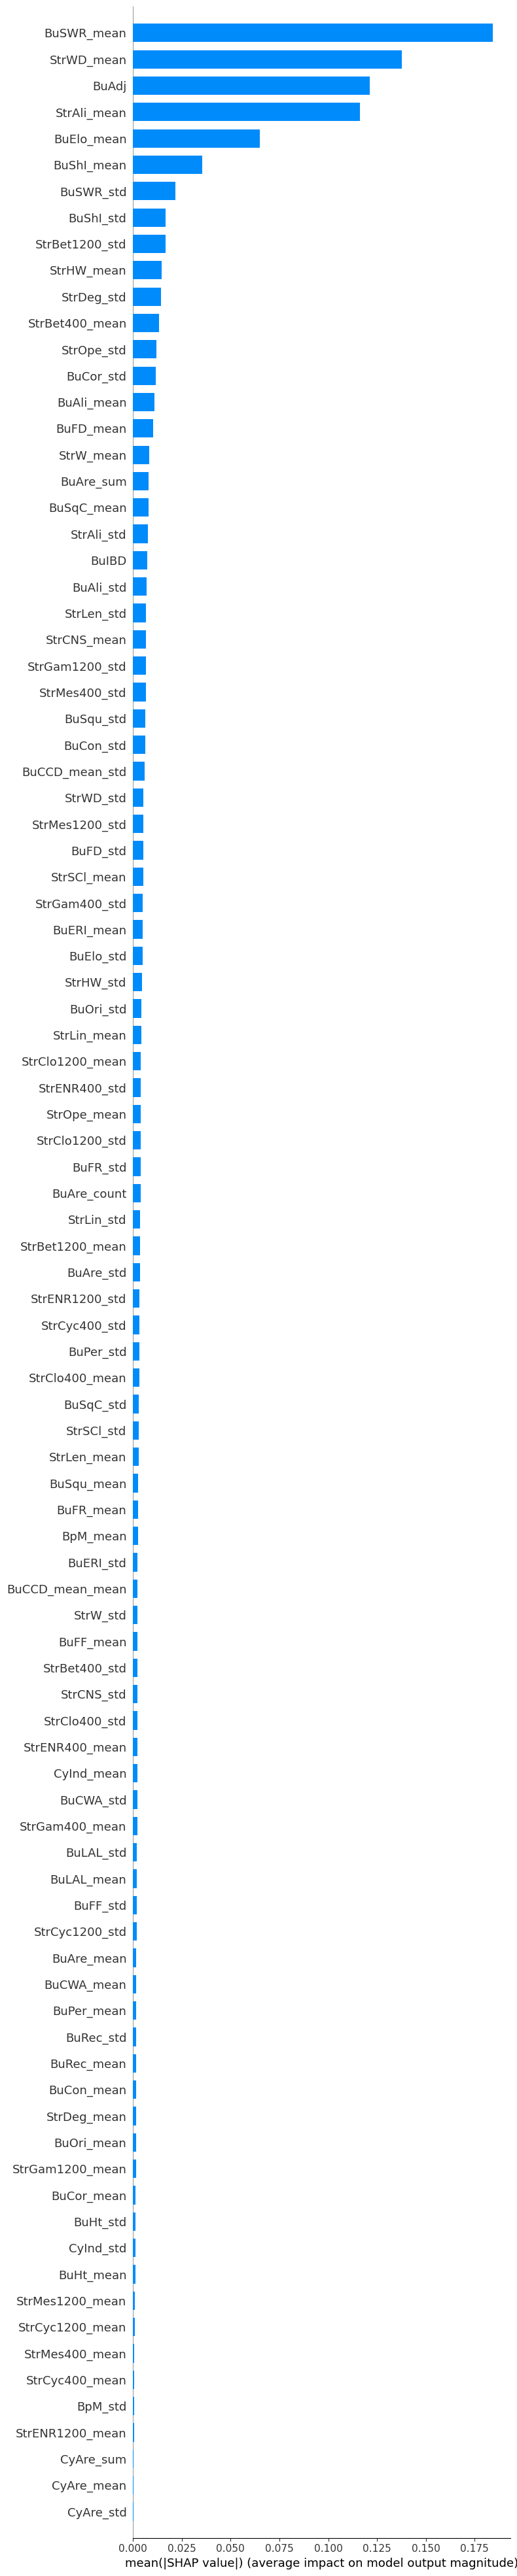

In [47]:
# show shap values for random forest
import shap

explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test, plot_type='bar',max_display=X_test.shape[1])


In [40]:
shap_values

array([[-1.16454742e-03,  2.10743242e-02,  1.41185173e-03,
         2.91155433e-04, -1.38644605e-03,  1.83492933e-03,
         1.34368764e-03, -2.30668289e-03,  4.14981300e-03,
         8.39751869e-04,  1.40665737e-03,  7.48609557e-03,
        -5.88054868e-04,  2.08604894e-02, -2.14650293e-04,
        -2.84541966e-04, -1.63347975e-04, -2.31482535e-03,
        -7.69221446e-04,  3.22610365e-03, -2.11180196e-04,
        -2.85090603e-03, -8.66457440e-03,  5.52691630e-02,
        -5.85638183e-03,  2.79667812e-03,  2.82426823e-03,
        -8.74401289e-04, -6.16770944e-04,  8.90238672e-04,
        -6.88105188e-04,  1.04487440e-02,  1.45366719e-02,
        -1.16241605e-03,  1.90113982e-03,  2.83751322e-02,
        -6.32315356e-03, -5.37762084e-03,  3.26058941e-03,
        -3.06893768e-03,  2.47147429e-03, -1.90531749e-01,
        -1.92755781e-03, -2.38792712e-01, -3.70190937e-02,
        -1.75465803e-03, -3.41063976e-04,  5.25184771e-03,
        -1.53001001e-02,  7.29194479e-02, -8.59144129e-0